## Improving Hierarchical Dirichlet processes with selection effects

Useful links for packages:
* [Pomegranate documentation](https://pomegranate.readthedocs.io/en/latest/)
* [Itertools documentation](https://docs.python.org/3.7/library/itertools.html)

In [26]:
import dpmix_exp as dp
import numpy as np
import itertools as itt
import matplotlib.pyplot as plt
import pomegranate as pg
from pomegranate import MultivariateGaussianDistribution as MVN
from pomegranate import GeneralMixtureModel as GMM

### Mock population
Let's create a mock population from which the event will be drawn. This is going to be what the parent Dirichlet process will try to infer on.
* First cluster around `[10,10]` (the problem is two dimensional in this example)
* Second cluster at bigger values `[50,50]`
* Both clusters have true weights equal `.5`
* Both clusters have similar broadness (e.g covariance matrix `[[16,0],[0,16]]`)

In [38]:
means = [[10, 10], [50, 50]]
cov = [[16, 0], [0, 16]]
pop_model = GMM(distributions = [MVN(means[0], cov), MVN(means[1], cov)], 
                weights = [0.5, 0.5])

Here is the probability distribution we are interested to infer on:

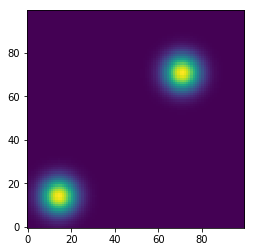

In [136]:
x = np.linspace(0,70,100)
points = np.array([p for p in itt.product(x,x)])
prob = pop_model.probability(points).reshape(100,100)
plt.imshow(prob, origin="bottom left")
plt.show()

### Mock events

Let's generate a few samples (e.g. 30 points).

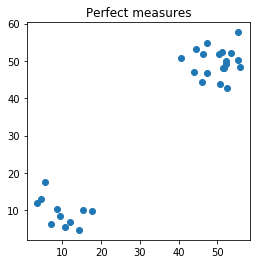

In [43]:
events = pop_model.sample(30)
plt.figure(1, (4,4))
plt.title("Perfect measurement")
plt.scatter(events[:, 0],events[:, 1])
plt.show()

These points are idealized perfect measurement of the two parameters we are interested in, which we don't have access to in real life.
Our data analysis pipeline perform a Bayesian parameter estimation, and produce as output a set of posterior samples for each event.
We mimick those using a fixed distribution (e.g. $\mathcal{N}(\mu_i,\sigma)$, where $\mu_i$ is the value sampled in `events`).
This is what the child Dirichlet process is supposed to reconstruct.

In [71]:
data = []
for e in events:
    nsample = int(np.random.uniform(low=1000, high = 3000))
    blob = MVN(e, [[4,2],[2,4]])
    posterior_samples = blob.sample(int(nsample))
    data.append(posterior_samples)

Let's plot all of them together 

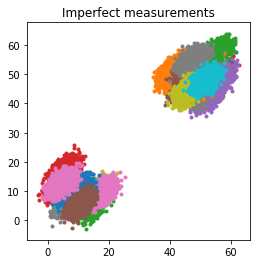

In [72]:
plt.figure(2, (4,4))
for d in data:
    plt.title("Imperfect measurements")
    plt.scatter(d[:, 0],d[:, 1], marker='.')
plt.show()

## Real data

In the real situation, here are the 11 events we have available. The posterior samples are distributed according to some unknown distributions, whose contours are shown in the picture below.

![Example](https://ligo.org/science/Publication-O2Catalog/images/fig2_o2-masses.png)

Main task of my inference problem is to reconstruct the population of such events, and providing a probability of pertaining to a given cluster.
We do not know how many cluster are needed, and we don't know the shape of the individual event blobs, that's why I decided to use the Hierarchical Dirichlet process.

In [103]:
HDPmodel = dp.HDPNormalMixture(data, ncomp=2)
HDPmodel.sample(niter=1000, nburn=30) # It may take a few minutes to run...

Here are the two centroids I'm looking for

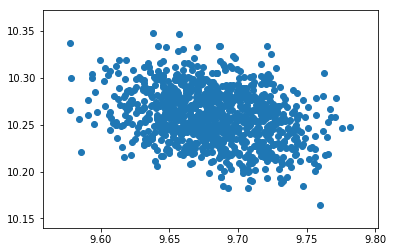

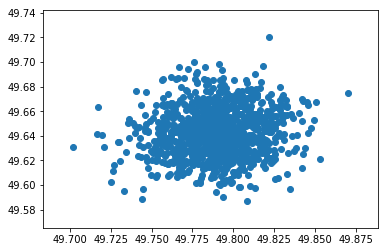

In [108]:
plt.scatter(HDPmodel.mu[:,0,0], HDPmodel.mu[:,0,1])
plt.show()
plt.scatter(HDPmodel.mu[:,1,0], HDPmodel.mu[:,1,1])
plt.show()

And here is the inference on their weights

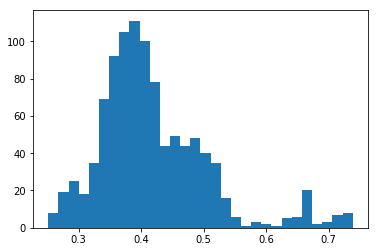

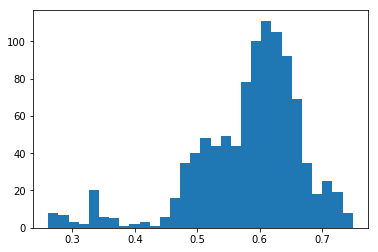

In [109]:
plt.hist(HDPmodel.beta[:,0], bins=30)
plt.show()
plt.hist(HDPmodel.beta[:,1], bins=30)
plt.show()

### Including selection effects

The last ingredient in my analysis are selection effects.
For a given `event`, there is a non-negligible probability of not detecting it (and therefore not including it in the data). Our knowledge of the detector provides enough information to compute, via simulations, such probability, **for each given population**. It is the dependence on the population that makes it impossible to apply it _a posteriori_. In order to do it coherently, I have to do it during the model sampling. 

From an inference point of view, given a sampled **population** (a sample of the parent Dirichlet process), including my selection effects is totally equivalent to changing the population normalization when we evaluate the likelihood of the data given the population. This is meant to compensate for our bias given the detection pipeline that we employ. I have a class to compute the normalization
It is difficult to explain it in greater details, without describing the entire framework:

[ https://arxiv.org/abs/1809.02063 ]

#### Mock selection effects

The function provided below does not make any physical sense, it's just something spitting a number for a given gaussian mixture population. For example, if for some reason we are less sensitive to populations with very unequal weights, the selection effects would need to compensate for it. 

Let's say that the following function does the job for us, if it is used to divide the likelihood. 

In [140]:
def select(self, mu, sigma, weights):
    return np.min(weights)

The way this function is written, it tends to "prefer" (or to be precise to compensate for us disfavouring) mixture components with  unequal weights (e.g. `weights=[0.9, 0.1]`). dividing the likelihood by a small number (e.g. `0.1`)

For example, let's say the sampler proposes a population with very unequal weights `[0.1, 0.9]`:
even if our data contains a mixture with true weights `[0.5, 0.5]` the selection effects will artificially increase the likelihood of our data (low by itself), because it is rare for us to observe such population.

So now the question is: which lines of code should we change?